<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn import functional as F

In [3]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [4]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/"
FILENAME = "data_10.json"

In [5]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [6]:
def train_val_test_split(X, y, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# load data
X, y = load_data(DATA_PATH+FILENAME)

# create train/test split
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.1)

Data succesfully loaded!


In [8]:
print("train, val, test mfccs")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print("train, val, test targets(labels)")
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

train, val, test mfccs
(7996, 130, 13)
(1000, 130, 13)
(1000, 130, 13)
train, val, test targets(labels)
(7996,)
(1000,)
(1000,)


In [9]:
from torch.utils.data import TensorDataset, DataLoader

tensor_X_train = torch.Tensor(X_train)
tensor_X_val = torch.Tensor(X_val)
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(tensor_X_train,tensor_y_train)
val_dataset = TensorDataset(tensor_X_val,tensor_y_val)
test_dataset = TensorDataset(tensor_X_test,tensor_y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [58]:
class CNN(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
### Convolutional layer
      
      nn.Conv2d(1,256,kernel_size=(3,3), padding=1),
      nn.ReLU(),
      nn.Conv2d(256,256,kernel_size=(3,3), padding=1),
      nn.ReLU(),
      nn.AvgPool2d(3, stride=2),
      nn.BatchNorm2d(256),
      nn.Conv2d(256,256,kernel_size=(3,3), padding=1),
      nn.ReLU(),
      nn.AvgPool2d(3, stride=2),  
      nn.BatchNorm2d(256),
      nn.Conv2d(256,512,kernel_size=(4,4), padding=1),
      nn.ReLU(),
      nn.AvgPool2d(1, stride=2),
      nn.BatchNorm2d(512),

### Fully-connected layer
      nn.Flatten(),
      nn.ReLU(),

      nn.Linear(7680, 256),
      nn.ReLU(),
      nn.Dropout(p=0.2),

      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(p=0.2),

      nn.Linear(128, 10),
      nn.Softmax()
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [11]:
def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()

In [12]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [13]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

In [60]:
train_acc = []
val_acc = []

lr = 0.0005
n_epochs = 200
iterations_per_epoch = len(train_dataloader)
best_acc = 0
patience, trials = 30, 0

model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):

    
    tcorrect, ttotal = 0, 0
    for (x_batch, y_batch) in train_dataloader:
        model.train()
        x_batch = x_batch.unsqueeze(1)
        x_batch, y_batch = [t.cuda() for t in (x_batch, y_batch)]
        y_batch = y_batch.to(torch.int64)
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

        _,pred = torch.max(out, dim=1)
        ttotal += y_batch.size(0)
        tcorrect += torch.sum(pred==y_batch).item()

    train_acc.append(100 * tcorrect / ttotal)
    
    model.eval()
    vcorrect, vtotal = 0, 0
    for x_val, y_val in val_dataloader:
        x_val = x_val.unsqueeze(1)
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        vtotal += y_val.size(0)
        vcorrect += (preds == y_val).sum().item()
    
    vacc = vcorrect / vtotal
    val_acc.append(vacc*100)

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Val Acc.: {vacc:2.2%}')

    if vacc > best_acc:
        trials = 0
        best_acc = vacc
        torch.save(model, DATA_PATH+"model")
        print(f'Epoch {epoch} best model saved with val accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 best model saved with val accuracy: 48.30%
Epoch 2 best model saved with val accuracy: 57.70%
Epoch 4 best model saved with val accuracy: 62.30%
Epoch:   5. Loss: 1.7918. Val Acc.: 55.40%
Epoch 6 best model saved with val accuracy: 64.10%
Epoch 8 best model saved with val accuracy: 66.40%
Epoch:  10. Loss: 1.8571. Val Acc.: 70.20%
Epoch 10 best model saved with val accuracy: 70.20%
Epoch 14 best model saved with val accuracy: 71.70%
Epoch:  15. Loss: 1.7290. Val Acc.: 65.10%
Epoch 16 best model saved with val accuracy: 72.40%
Epoch 18 best model saved with val accuracy: 74.80%
Epoch:  20. Loss: 1.7751. Val Acc.: 74.20%
Epoch 22 best model saved with val accuracy: 76.10%
Epoch 24 best model saved with val accuracy: 76.70%
Epoch:  25. Loss: 1.6656. Val Acc.: 72.80%
Epoch 28 best model saved with val accuracy: 77.00%
Epoch:  30. Loss: 1.5707. Val Acc.: 78.40%
Epoch 30 best model saved with val accuracy: 78.40%
Epoch 34 best model saved with val accuracy: 80.20%
Epoch:  35. Loss: 1

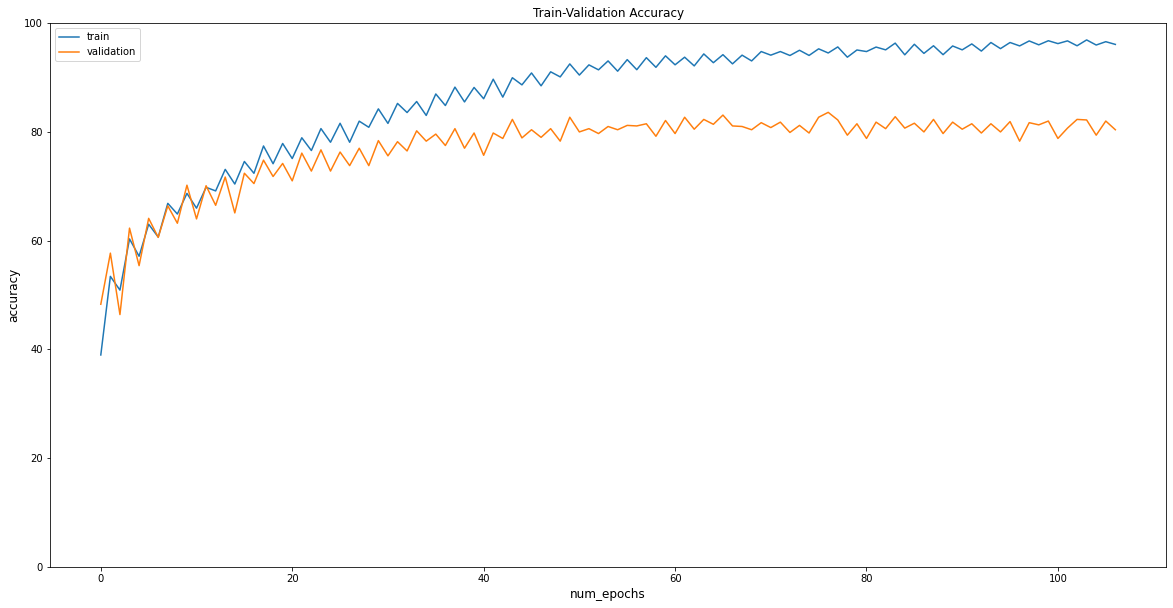

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(val_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.ylim((0,100))
#plt.xlim((0,n_epochs))

plt.legend(loc='best')

In [62]:
#Evaluate on test dataset

torch.no_grad()
count = 0
correct = 0

true = []
preds = []

model=model.to(device)

for X_testbatch, y_testbatch in test_dataloader:
    X_testbatch = X_testbatch.unsqueeze(1).to(device)
    y_testbatch = y_testbatch.to(device)

    y_val = model(X_testbatch)
        
    predicted = torch.max(y_val,1)[1]
    
    count+= y_testbatch.size(dim=0)
    correct += (predicted == y_testbatch).sum()

    true.append(y_testbatch)
    preds.append(predicted)

ground_truth = torch.cat(true)
predicted_genres = torch.cat(preds)
print(f'Test accuracy: {correct.item()}/{count} = {correct.item()*100/(count):7.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test accuracy: 813/1000 =   81.30%


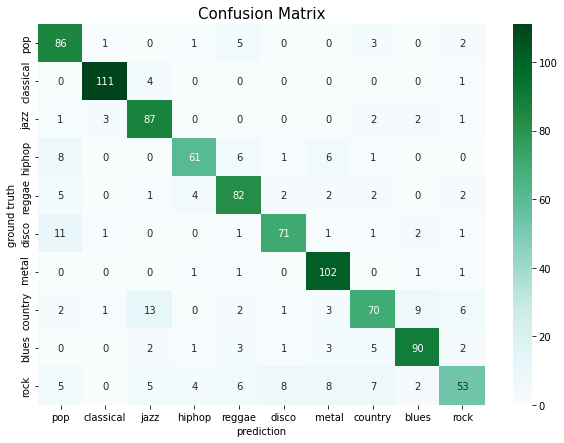

In [63]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(ground_truth.view(-1).detach().cpu().numpy(), predicted_genres.view(-1).detach().cpu().numpy())
class_names = ['pop', 'classical', 'jazz', 'hiphop', 'reggae', 'disco', ' metal', 'country', 'blues', 'rock']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.title('Confusion Matrix', fontsize=15)
plt.show() 
